In [1]:
import numpy as np
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import plot_model

1/1 [==============================] - 1s 1s/step
Predicted: [('n01665541', 'leatherback_turtle', 0.9608966)]


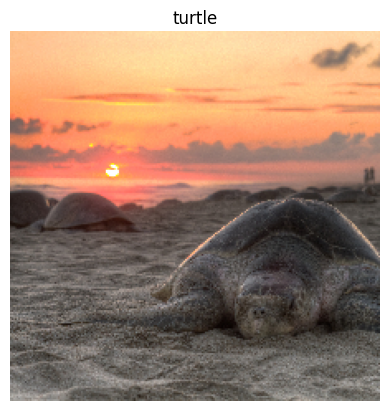

In [2]:
from matplotlib import pyplot as plt

model = ResNet50(weights='imagenet')

img_path = "..\\turtle.jpg"""
img = image.load_img(img_path, target_size=(224, 224), keep_aspect_ratio=True)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(preprocess_input(x))

preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=1)[0])
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title("turtle")
plt.show()

In [20]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [24]:
model.non_trainable_weights

[<tf.Variable 'conv1_bn/moving_mean:0' shape=(64,) dtype=float32, numpy=
 array([-0.1512462 , -0.64193594, -0.5950486 ,  0.5573925 ,  0.04964633,
        -1.3543581 , -0.55720747,  0.7028118 ,  0.72205496, -0.06209099,
         0.12961772,  0.04776215,  0.00559795, -1.2660099 ,  0.33788112,
         0.56091577, -0.64116454, -0.07362732, -0.24347433,  0.08685432,
        -0.10537097,  0.09455026, -2.3035636 ,  0.009311  , -0.07884994,
        -0.09572847,  1.5617214 , -0.159881  ,  0.11597473,  0.7430062 ,
         0.46179256, -0.17867799,  0.19140534, -0.05171439,  2.7138855 ,
         0.12593503, -0.25815797,  0.1700401 ,  3.334259  , -1.4724497 ,
         0.36282057,  0.05076902, -0.14957784,  0.31851518,  0.05544581,
         2.1343627 , -0.00823953, -0.4773408 , -0.45457822, -0.07698756,
         2.9924777 ,  0.7342864 ,  0.11639247, -0.20091796, -0.6945088 ,
         0.05711879, -0.49359688, -0.25796604, -0.26115438,  0.05262396,
         0.21160594, -0.27037546, -3.5374024 , -0.0

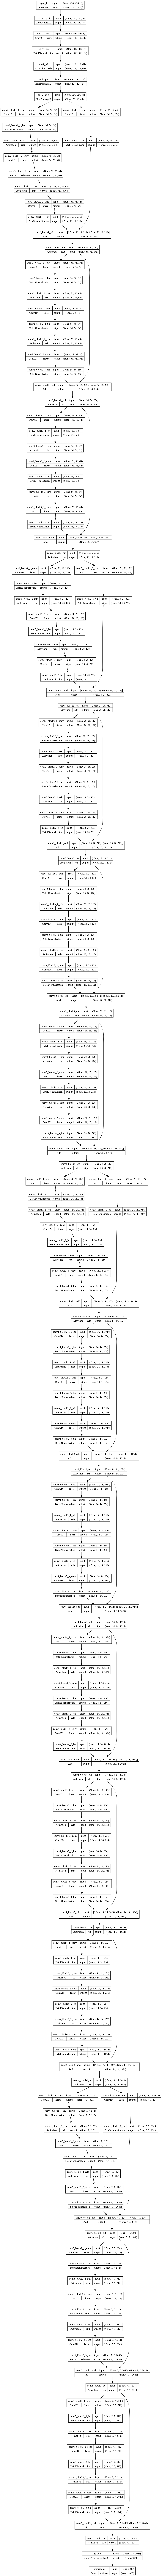

In [3]:
plot_model(model, show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [ ]:
model.summary()

In [ ]:
for i in range(len(model.layers)):
    print(str(i) + ":", model.get_layer(index=i))

In [ ]:
from resnet50.utils import split_functional_model

head, tail = split_functional_model(model, 7)

In [ ]:
plot_model(head, show_layer_names=True, show_shapes=True)

In [ ]:
plot_model(tail, show_layer_names=True, show_shapes=True)

In [ ]:
inter = head.predict(x)
out = tail.predict(inter)
print('Predicted:', decode_predictions(preds, top=5)[0])
print('Predicted:', decode_predictions(out, top=5)[0])

In [ ]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 224, 224, 3)
        yield [data.astype(np.float32)]


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()

# Save the model.
with open('full_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.int8)
input_data = tf.image.convert_image_dtype(x, dtype=tf.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print('Predicted:', decode_predictions(output_data, top=5)[0])

In [ ]:
plt.figure()
plt.imshow(input_data[0])
plt.axis('off')
plt.title("turtle")
plt.show()